In [3]:
%matplotlib widget
import os
from pathlib import Path
import sys
sys.path.append(str(Path(os.getcwd()).parent.parent))
from src.utils import ElevationHandler, transform_coordinates
import numpy as np
import matplotlib.pyplot as plt

In [3]:
tempeature = 20 # [deg C]
c = 331.5 * np.sqrt(1 + tempeature / 273.15) # speed of sound in air [m/s]
f = 1000 # frequency [Hz]
wavelength = c/f # [m]
d = 1
dp = 1 # source-to-receiver distance, in metres, projected onto the ground planes [m]

In [4]:
def calcA(f, h, G):
    """
    Input:
        f : float
            frequency [Hz]
        h : float
            height of source / receiver above ground [m]
        G : float
            ground factor for source / receiver
    Output.
        A : float
            ground attenuation contributions [dB]

    """
    if f == 63:
        A = -1.5
    elif f == 125:
        aPrime = 1.5 + 3.0 * np.exp(-0.12*(h - 5)**2) * (1 - np.exp(-dp/50)) + 5.7 * np.exp(-0.09 * h**2) * (1 - np.exp(-2.8 * 10**(-6) * dp**2))
        A = -1.5 + G * aPrime
    elif f == 250:
        bPrime = 1.5 + 8.6 * np.exp(-0.09*h**2) * (1 - np.exp(-dp/50))
        A = -1.5 + G * bPrime
    elif f == 500:
        cPrime = 1.5 + 14.0 * np.exp(-0.46*h**2) * (1 - np.exp(-dp/50))
        A = -1.5 + G * cPrime
    elif f == 1000:
        dPrime = 1.5 + 5.0 * np.exp(-0.9*h**2) * (1 - np.exp(-dp/50))
        A = -1.5 + G * dPrime
    elif f in (2000, 4000, 8000):
        A = -1.5*(1 - G)
    else:
        print("Invalid nominal midband frequency!")
        A = 0
    return A

def calcAm(f, dp, hs, hr, Gm):
    """
    Input:
        f : float
            frequency [Hz]
        dp : float
            source-to-receiver distance, in metres, projected onto the ground planes [m]
        hs : float
            height of source above ground [m]
        hr: float
            height of receiver above ground [m]
        Gm : float
            ground factor for middle region
    Output.
        Am : float
            ground attenuation contributions for middle region [dB]

    """
    if dp <= 30 * (hs + hr):
        q = 0
    else:
        q = 1 - (30 * (hs + hr))/dp
    Am = 3 * q * (1 - Gm)
    return Am

class Line():
    def __init__(self, startPoint, endPoint):
        self.startPoint = startPoint
        self.endPoint = endPoint

    def length_3d(self):
            """
            Calculate the 3D length of the line.
            """
            x1, y1, z1 = self.startPoint
            x2, y2, z2 = self.endPoint

            distance_3d = np.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)
            return distance_3d

    def length_2d(self):
        """
        Calculate the projected 2D length of the line.
        """
        x1, y1, _ = self.startPoint
        x2, y2, _ = self.endPoint

        distance_2d = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        return distance_2d


In [5]:
Gr = Gs = Gm = 1 # for Porous ground (Implement mixed ground)
startPoint = np.array([0, 0, 0])
endPoint = np.array([10, 10, 10])
SR_line = Line(startPoint, endPoint)
d = SR_line.length_3d()
dp = SR_line.length_2d()
hs = 100 # height source [m]
hr = 0 # height receiver [m]
As = calcA(f, hs, Gs)
Ar = calcA(f, hr, Gr)
Am = calcAm(f, dp, hs, hr, Gm)
Agr = As + Ar + Am

hm = (hs + hr) / 2
Agr = 4.8 - (2 * hm / d) * (17 + (300 / d))
if Agr < 0:
    Agr = 0


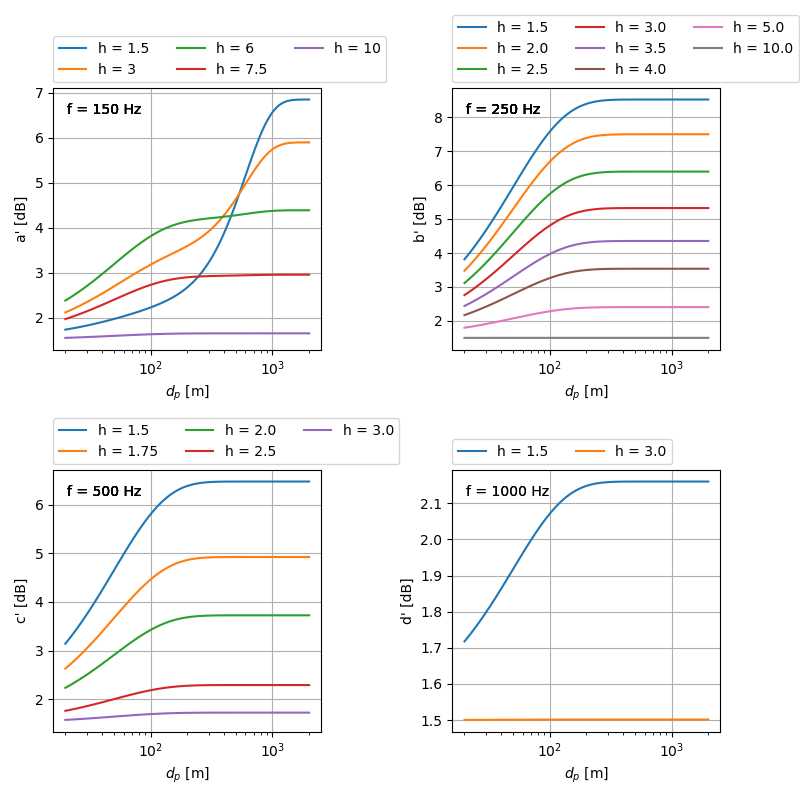

In [46]:
fs = [150, 250, 500, 1000]
dp = np.logspace(np.log10(20), np.log10(2000), 100)
hs = [[1.5, 3, 6, 7.5, 10], [1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 5.0, 10.0], [1.5, 1.75, 2.0, 2.5, 3.0], [1.5, 3.0]]

fig, axes = plt.subplots(2, 2, figsize = (8,8))
for i, f in enumerate(fs):
    for h in hs[i]:
        if i == 0:
            aPrime = 1.5 + 3.0 * np.exp(-0.12*(h - 5)**2) * (1 - np.exp(-dp/50)) + 5.7 * np.exp(-0.09 * h**2) * (1 - np.exp(-2.8 * 10**(-6) * dp**2))
            axes[0, 0].semilogx(dp, aPrime, label = f"h = {h}")
            axes[0, 0].grid(True)
            axes[0, 0].set(ylabel = "a' [dB]")
            axes[0, 0].text(0.05, 0.9, f"f = {f} Hz", transform=axes[0, 0].transAxes)
        if i == 1:
            bPrime = 1.5 + 8.6 * np.exp(-0.09*h**2) * (1 - np.exp(-dp/50))
            axes[0, 1].semilogx(dp, bPrime, label = f"h = {h}")
            axes[0, 1].grid(True)
            axes[0, 1].set(ylabel = "b' [dB]")
            axes[0, 1].text(0.05, 0.9, f"f = {f} Hz", transform=axes[0, 1].transAxes)
        if i == 2:
            cPrime = 1.5 + 14.0 * np.exp(-0.46*h**2) * (1 - np.exp(-dp/50))
            axes[1, 0].semilogx(dp, cPrime, label = f"h = {h}")
            axes[1, 0].grid(True)
            axes[1, 0].set(ylabel = "c' [dB]")
            axes[1, 0].text(0.05, 0.9, f"f = {f} Hz", transform=axes[1, 0].transAxes)
        if i == 3:
            dPrime = 1.5 + 5.0 * np.exp(-0.9*h**2) * (1 - np.exp(-dp/50))
            axes[1, 1].semilogx(dp, dPrime, label = f"h = {h}")
            axes[1, 1].grid(True)
            axes[1, 1].set(ylabel = "d' [dB]")
            axes[1, 1].text(0.05, 0.9, f"f = {f} Hz", transform=axes[1, 1].transAxes)

plt.setp(axes, xlabel=r'$d_p$ [m]')
axes[0, 0].legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
                      ncols=3, borderaxespad=0.)
axes[0, 1].legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
                      ncols=3, borderaxespad=0.)
axes[1, 0].legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
                      ncols=3, borderaxespad=0.)
axes[1, 1].legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
                      ncols=3, borderaxespad=0.)

plt.tight_layout()